This notebook is complete and is only for using as a reference for comparison to the plug-and-play method that you should implement. You don't need to change anything here. 

#### Total Variation Minimization to recover an image from undersampled measurements

The loss function minimzed is: $||Ax - y||_2^2 + \lambda ||x||_{\mathrm{TV}}$, where $||x||_{\mathrm{TV}} = \sum_{i,j} |x_{i+1, j} - x_{i,j}| + |x_{i,j+1} - x_{i,j}|$

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch

from PIL import Image
!pip install bm3d
import bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.4 MB 4.3 MB/s 


In [ ]:
img = Image.open("camera_man.png")     #Load the camera man image (remember to upload the photo)
x = np.float32(img)/255                #Convert to array
x = torch.FloatTensor(x)

In [ ]:
# Measurement Matrix
a,b = x.shape   # 128 x 128

n= a*b           
m= n//2         # 2 times acceleration

# Measurement matrix M is Gaussian, mean 0, variance 1
np.random.seed(0)
M=np.random.randn(m,n)
M=torch.FloatTensor(M)

In [ ]:
#Forward Model A
def A(x: torch.Tensor)-> torch.Tensor:
    x = torch.reshape(x,(a*b,)) #Flatten into vector
    return M@x

def AT(y: torch.Tensor)-> torch.Tensor:
     return torch.reshape((M.T@y),(a,b))

def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

# Total-variation norm regularization 
def tv_loss(img: torch.Tensor) -> torch.Tensor:
    
    xdif = img[1:, :] - img[:-1, :]
    ydif = img[:, 1:] - img[:, :-1]

    return xdif.abs().sum() + ydif.abs().sum() 


In [ ]:
y = A(x)       #Observation
 
x_i = AT(y).clone()     # initial coarse estimate of the image 

In [ ]:
print('x', x)
print('y', y)
print('x_i', AT(y).clone())

x tensor([[0.6157, 0.6157, 0.6157,  ..., 0.6078, 0.6000, 0.6000],
        [0.6157, 0.6157, 0.6196,  ..., 0.6078, 0.6039, 0.6000],
        [0.6078, 0.6118, 0.6157,  ..., 0.5882, 0.5843, 0.5961],
        ...,
        [0.4549, 0.4275, 0.4824,  ..., 0.4000, 0.3882, 0.4118],
        [0.4745, 0.4510, 0.4706,  ..., 0.4471, 0.4980, 0.4863],
        [0.4863, 0.5255, 0.5412,  ..., 0.4980, 0.5059, 0.4863]])
y tensor([-86.1495, -21.1409, -21.4727,  ..., 230.0641,  16.3369, -93.4474])
x_i tensor([[  8639.8037,   3146.2073,  -5652.5488,  ...,   7597.5122,
          10248.0771,  -2245.7239],
        [  6334.2500,  21298.7734,   2256.7659,  ...,    447.2787,
           4628.5054,    359.2085],
        [   529.0467,   4470.3013,   3299.9861,  ...,   8819.6934,
         -11842.1895,  10186.4053],
        ...,
        [  5481.2271,     70.1413,   6201.1875,  ...,   7111.8926,
         -12114.1230,   1203.9174],
        [  5857.7993, -12337.9678,   5327.9917,  ...,  -4069.4563,
           2444.1841,  1821

In [ ]:
train_iter = 5000
alpha = 0.1
lamda = 0.001

for i in tqdm(range(train_iter+1)):
    
    x_i.requires_grad_()
    loss = mse(A(x_i),y) + lamda*tv_loss(x_i)
    loss.backward()
    
    with torch.no_grad():
        if i % 100 == 0:
            print(x_i.grad)
        x_i  = x_i - alpha * x_i.grad
        x_i.grad = None
    
    if i % 100 == 0:
        print(i,mse(x,x_i))
    

  0%|          | 0/5001 [00:00<?, ?it/s]

tensor([[  64520.1992,   35827.7461,  -61832.7539,  ...,   37190.1211,
           29812.3047,  -25748.7871],
        [  24230.5703,  145732.7969,   24779.4629,  ...,  -21787.7285,
            8511.5615,   19008.0996],
        [ -35422.9805,   11409.8242,   -4605.0879,  ...,   73832.0703,
         -101100.8281,   58499.3125],
        ...,
        [  30435.9473,   -4093.3618,   45646.8984,  ...,   36095.0352,
         -102553.8438,    8324.6240],
        [  60453.5508,  -91664.0859,   24670.9199,  ...,  -41424.2148,
          -11384.0967,  148326.6406],
        [  32052.7246,   72112.2656,   74532.7188,  ...,   22956.6758,
          -23740.8242,  -25455.8887]])
0 tensor(7262845.)
tensor([[-1.1354,  1.6565, -1.0552,  ..., -0.4241,  0.0798,  0.3856],
        [-0.9219, -1.2240, -0.8206,  ..., -0.3846,  0.1194,  1.2007],
        [ 0.6423,  0.1566, -0.2635,  ..., -1.3532, -0.7222, -0.7133],
        ...,
        [ 0.0152,  0.2355, -0.1818,  ...,  0.1563,  1.1167, -0.8007],
        [-0.0170,  0

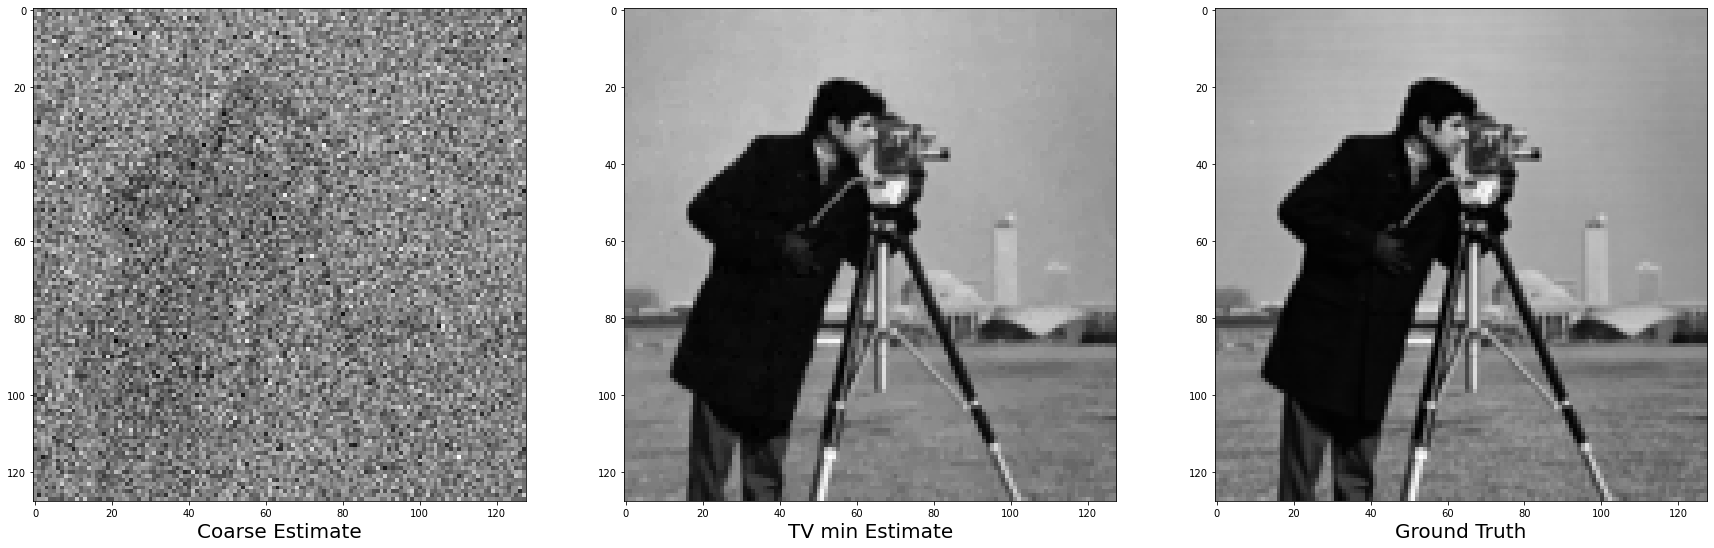

In [ ]:
fig = plt.figure(figsize=(30, 30))

#Coarse Estimate (A.T@y)
fig.add_subplot(1, 3, 1)
plt.imshow(AT(y), cmap='gray')
plt.xlabel('Coarse Estimate', fontsize=20)

#TV minimization estimate 
fig.add_subplot(1, 3, 2)
plt.imshow(x_i.detach(), cmap='gray')
plt.xlabel('TV min Estimate', fontsize=20)

#Ground Truth
fig.add_subplot(1, 3, 3)
plt.imshow(x, cmap='gray')
plt.xlabel('Ground Truth', fontsize=20)

plt.show()